Squeeze pretrained model - train only last conv layer for CIFAR10:
batch size = 128
Epochs = 20
Learning rate = 0.001
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
       

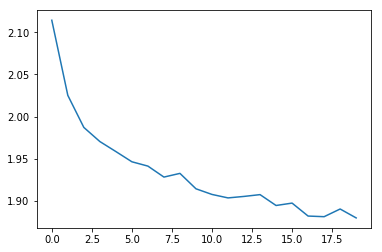

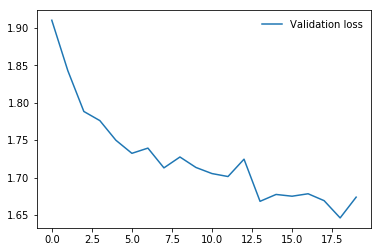

In [0]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time, copy, os
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

data_dir = "./data"
model_name = "densenet"
num_classes = 10            #CIFAR10
batch_size = 128
epochs = 20
learning_rate = 0.001
dropout1 = .4
dropout2 = .4 

print('Squeeze pretrained model - train only last conv layer for CIFAR10:')
print('batch size = 128')
print('Epochs = 20')
print('Learning rate = 0.001')

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(num_classes, feature_extract, use_pretrained=False):
    '''
    model_ft = models.squeezenet1_1(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model_ft.num_classes = num_classes
    input_size = 224
    '''
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, 256)
    input_size = 224
    return model_ft, input_size

model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=False)
print(model_ft)
model_ft = nn.Sequential(model_ft, 
                        nn.Dropout(p=dropout1), 
                        nn.Linear(256, num_classes),  
                        nn.Dropout(p=dropout2)
                        )


#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 0:
  print(torch.cuda.device_count(), "GPUs available")
  model_ft = nn.DataParallel(model_ft)

model_ft.to(device)

#LOAD DATA

'''
with open('./data/results3d.csv', 'w+') as f:
        #f.write('epoch,train_loss,train_error,valid_loss,valid_error,test_error\n')
          f.write('%03d,%0.6f,%0.6f,%0.6f \n' % (
                batch_size,
                learning_rate, 
                dropout1, 
                dropout2))        
'''

transform = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    )
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# model = model_ft
# if use_cuda:
#     model = model.cuda()

#OPTIMIZATION
params_to_update = model_ft.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update,lr=learning_rate)

train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    for images,labels in train_loader:
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
        train = Variable(images.view(-1,3,224,224))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        
        output = model_ft(train)
        # print(output.size())
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0


        with torch.no_grad(): #Turning off gradients to speed up
            model_ft.eval()
            for images,labels in test_loader:
                if use_cuda:
                    images, labels = images.cuda(), labels.cuda()
                test = Variable(images.view(-1,3,224,224))
                labels = Variable(labels)
                
                log_ps = model_ft(test)
                test_loss += criterion(log_ps,labels)
            
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model_ft.train()        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        train_l = running_loss/len(train_loader)
        test_l = test_loss/len(test_loader)
        acc = accuracy/len(test_loader)
        
        # Print results
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
            "Training Loss: {:.3f}.. ".format(train_l),
            "Test Loss: {:.3f}.. ".format(test_l),
            "Test Accuracy: {:.3f}".format(acc)
             )
        
        # Log results
        with open('./data/results44d.csv', 'a') as f:
          f.write('%03d,%0.6f,%0.6f,%0.5f,\n' % (
                (epoch + 1),
                train_l,
                test_l,
                acc,
            ))
        
        

plt.figure(1)
plt.plot(train_losses, label='Training loss')
plt.figure(2)
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()





